# Volatility and Price Movement Prediction
_Andrew Cachia, Feb 2019_

In [28]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model
import fix_yahoo_finance as yf
from scipy.special import ndtri
import matplotlib.pyplot as plt
import matplotlib as mpl

#### Downloading historic pricing for Apple and calculating returns

In [4]:
date_start = "2013-01-01"
date_end = "2017-11-30"

symbols = ['AAPL']

data = pd.DataFrame()
yf.pdr_override() 
data = pdr.get_data_yahoo(symbols, start=date_start, end=date_end)

returns = data['Adj Close'] / data['Adj Close'].shift(1)
returns = np.log(returns)
returns = returns.dropna()
returns.head()

[*********************100%***********************]  1 of 1 downloaded


Date
2013-01-02    0.031190
2013-01-03   -0.012702
2013-01-04   -0.028250
2013-01-07   -0.005900
2013-01-08    0.002688
Name: Adj Close, dtype: float64

In [5]:
daily_average_return = returns.mean()
print("Daily average return: {0:.3f}%".format(daily_average_return * 100))

Daily average return: 0.091%


### Measuring Volatility

###### Historical Method (Standard Deviation)

__Pros__
+ Most standard method
+ Easy to calculate and interpret

__Cons__
- Does not tell us the direction of change
- All returns are the same weight


###### Exponentially Weighted Moving Average

__Pros__
+ The EWMA approach to volatility is an improvement over simple volatility because it assigns greater weight to more recent observations (in fact, the weights are proportional), creating a bias towards recent observations.


__Cons__
- The disadvantage of this is that it is less indicative of longer term trends or cycles, and might not be very useful when used for predictions in the not so near future.



# Historic Volatility

In [6]:
volatility = returns.std();
variance = volatility**2;
returns_squared = returns**2;
print('Historic Volatility: %5.2f%%' % (volatility*100))

Historic Volatility:  1.54%


# Garch

In [7]:
am = arch_model(returns, vol='Garch', p=1, o=0, q=1, dist='Normal')
res = am.fit(update_freq=5)
print(res.summary())

condvol=res.conditional_volatility.iloc[-1]
print('\n\nVolatility - Garch(1,1): %5.2f%%' % (condvol*100))

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -3448.719551537086
            Iterations: 8
            Function evaluations: 50
            Gradient evaluations: 4
                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:                3448.72
Distribution:                  Normal   AIC:                          -6889.44
Method:            Maximum Likelihood   BIC:                          -6868.95
                                        No. Observations:                 1238
Date:                Sun, Feb 03 2019   Df Residuals:                     1234
Time:                        22:48:09   Df Model:                            4
                                 Mean Model                            

/home/andrew/anaconda3/envs/fin_eng/lib/python3.6/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


# Geometric Brownian Motion

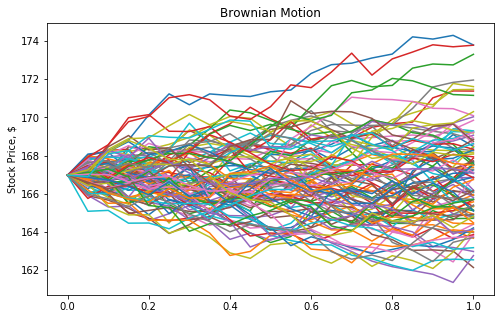

In [35]:
seed = 20

fig, ax = plt.subplots(1, 1,figsize=(8,5))
plt.title('Brownian Motion')
plt.ylabel('Stock Price, $')

final_prices = [];

#Generate random path
def Brownian(seed, N):
    np.random.seed(seed)            
    dt = 1./N  # time step
    b = np.random.normal(0., 1., int(N))*np.sqrt(dt)  # brownian increments
    W = np.cumsum(b)  # brownian path
    return W, b

#Apply random path to stock
def GBM(So, mu, sigma, W, N):    
    t = np.linspace(0.,1.,int(N+1))
    S = []
    S.append(So)
    for i in range(1,int(N+1)):
        drift = (mu - 0.5 * sigma**2) * t[i]
        diffusion = sigma * W[i-1]
        S_temp = So*np.exp(drift + diffusion)
        S.append(S_temp)
    return S, t

So = data['Adj Close'][len(data['Adj Close'])-1]
mu = daily_average_return
sigma = volatility
N = 20

for i in range(0,100):
    W = Brownian(i, N)[0]
    soln = GBM(So, mu, sigma, W, N)[0]    # Exact solution
    t = GBM(So, mu, sigma, W, N)[1]  
    
    ax.plot(t, soln)
    
    final_prices.append(soln[len(soln)-1])

The algorithm here performs 100 simulations, projecting a potential price path each time. For each simulation, a random Brownian path is computed by generating random numbers from a normal distribution.
These paths are then combined with the volatility and average return to reflect the potential motions faced by the stock price. The starting point of the GBM is the current price.

In [34]:
final_prices_vol =  np.std(final_prices)

alpha = ndtri(0.95)
VaR = alpha * final_prices_vol

print('VaR 95%: {0:.3f}'.format(VaR))

VaR 95%: 4.086
